# Overview

This notebook examines pig and poultry farms in the US. It is intended to help illustrate the distributions of building areas, lengths, and aspect ratios associated with these farms. Currently, two datasets are investigated:

1. A set of ~6000 poultry barns in the Delmarva Peninsula. These were [collected](https://www.sciencebase.gov/catalog/item/5e0a3fcde4b0b207aa0d794e) by the USGS using aerial imagery. The coordinates refer to actual buildings, and the shapefile contains building areas, so it is possible to directly analyze the building footprints. The authiors do not distinguish between broiler chickens, laying hens, and any other birds, and no other information about the farms (e.g. number of animals) is available.

2. A set of about 3000 liquid pig manure storage facilities in North Carolina. The lagoon coordinates were derived by Montefiore et al. from official permit information. The coordinates refer to lagoon centers. The only other information contained in the files is the estimated year of lagoon construction. As the coordinates of farm buildings are not supplied, they must be obtained from the global building footprint database. We do that by assuming that the buildings within a certain radius of the lagoon are the farm buildings.

Some conclusions:

1. The minimum poultry building area is 526 sq m. It seems that anything smaller than that either did not exist or was not recognized as a poultry barn

2. The pig farm data can't be interpreted as cleanly as the building dataset likely contains buildings other than animal housing. However, it seems like the median building size is considerably smaller than that of poultry housing, and aspect ratios are also lower.

In [1]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
from IPython.core.magic import register_cell_magic
from google.colab import drive
import ee
import geemap.foliumap as geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [3]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Delmarva Poultry

The Delmarva poultry dataset contains the building footprint information we need, so it is very easy to work with. We'll look at this one first. We can directly use the statistics about building areas,  lengths, and aspect ratios in comparisons with other datasets.

In [4]:
# Read in the DMV data and calculate lengths and aspect ratios

f = "/content/drive/MyDrive/CAFO_data/USA/Delmarva_PL_House_Final/Delmarva_PL_House_Final2.shp"
dmv = gpd.read_file(f)
dmv.rename(columns={"AreaMeters": "Area (sq m)"}, inplace=True)
dmv.loc[:, 'Farm type'] = 'Poultry'
dmv.loc[:, 'Number of animals'] = np.nan
display(dmv.head(2))

temp = dmv['geometry'].minimum_rotated_rectangle().to_crs('EPSG:32618')
dmv[['Length (m)', 'Aspect ratio']] = temp.apply(explore.calc_length_etc)

,Area (sq m),geometry,Farm type,Number of animals
0,2148,"POLYGON Z ((441154.142 4180879.337 0.000, 4410...",Poultry,NaN
1,3658,"POLYGON Z ((441081.382 4180936.884 0.000, 4409...",Poultry,NaN


,Area (sq m),Length (m),Aspect ratio
Min,526.0,51.048241,3.289669
Med,2319.0,153.258935,8.677511
Max,8107.0,247.856798,20.172176


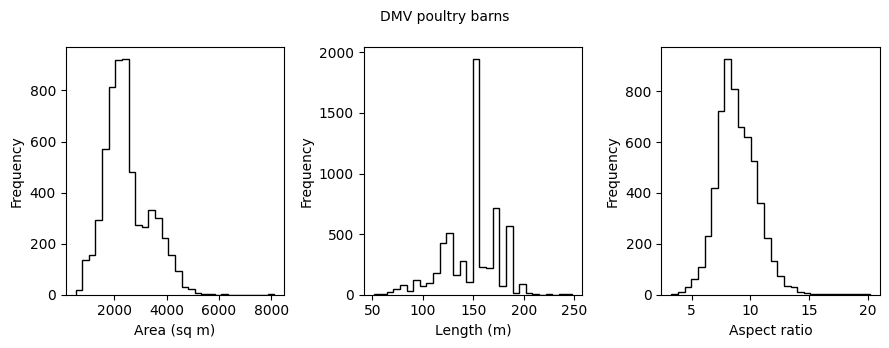

In [5]:
# Make histograms, calculate stats, save to file

default_bins = {}
default_bins['Area (sq m)'] = 30
default_bins['Length (m)'] = 30
default_bins['Aspect ratio'] = 30
explore.show_n_save(dmv, default_bins, "DMV_poultry_bldg_histos", "DMV_poultry_bldg_stats",\
            "DMV poultry barns")

We'll also look at aspect ratio vs area. I'm not yet totally sure how this could be used, but it feels like understanding where various types of farm buildings (and not-farm buildings) sit in this space.

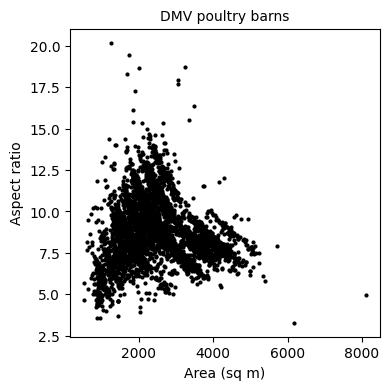

In [6]:
def aspect_area(df, title, lims=None):

  _, ax = plt.subplots(1, 1, figsize=(4, 4))
  ax.scatter(df['Area (sq m)'], df['Aspect ratio'], marker='o',\
              s=4, color='k')
  if lims is not None:
    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
  ax.set_xlabel("Area (sq m)")
  ax.set_ylabel("Aspect ratio")
  ax.set_title(title, fontsize=10)

aspect_area(dmv, "DMV poultry barns")

## North Carolina pig waste lagoons

Now we'll look at the North Carolina Data. This is more involved because we only have lagoon locations, not building locations. We'll get building locations by finding buildings within a certain distance of the lagoons. This probably means we miss some buildings and include others that aren't relevant, depending on farm characteristics, but we'll have to live with that.

In [7]:
# Read the lagoon data

lagoons = gpd.read_file("/content/drive/MyDrive/CAFO_data/USA/Montefiore.shp").to_crs("EPSG:4326")
lagoons.drop(columns=["field_1", "field_2", "field_3"], inplace=True)
lagoons.loc[:, "Farm type"] = "Pigs"
lagoons.loc[:, 'Number of animals'] = np.nan

print(f"There are {len(lagoons)} lagoons in the dataset")
display(lagoons.head(2))

lagoons_fc = geemap.geopandas_to_ee(lagoons[["geometry"]])

There are 3405 lagoons in the dataset


,geometry,Farm type,Number of animals
0,POINT (-77.74930 35.40588),Pigs,NaN
1,POINT (-77.65778 35.39197),Pigs,NaN


In [8]:
# Read the NC state shapefile and find all buildings above 200 sq m
# We have to exclude small buildings to keep the data volume manageable
# (Even so, we still end up with about 2 million buildings)

nc = gpd.read_file('/content/drive/MyDrive/CAFO_data/USA/cb_2021_us_state_5m.shp')
nc = nc[nc['NAME'].str.match('North Carolina')]
nc_geom = geemap.geopandas_to_ee(nc[['geometry']])

min_building_size = 200

buildings = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/USA")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      .filterBounds(nc_geom)
)

In [9]:
# Show all buildings and lagoons on a map. I've only looked at this map a little
# bit, as a basic sanity check. However, I've worked with this dataset before and
# I expect everything to be OK.

Map = geemap.Map()
Map.centerObject(nc_geom.first().geometry(), 10)

os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

region_viz = {'color':'red', 'fillColor':'00000000'}
building_viz = {'color':'orange', 'fillColor':'00000000'}

Map.add_basemap("HYBRID")
Map.addLayer(buildings.style(**building_viz), {}, "")
Map.addLayer(lagoons_fc, {'color':'pink', 'width':6}, "Pig lagoons")

Map

In [10]:
%%skip
# Save the buildings to a file for future use. This is time-consuming so leave
# this cell commented out unless there's a reason to recreate the file.

utils.write_to_file(buildings, f"NC_{min_building_size}m2", 'USA')
utils.ee_task_status()

In [11]:
# Read the data into a geodataframe (takes about 4.5 mins)

gdf = gpd.read_file(f"/content/drive/MyDrive/CAFO_data/USA/NC_{min_building_size}m2.geojson")
gdf.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(gdf)} buildings > {min_building_size} sq m")

There are 1955891 buildings > 200 sq m


In [12]:
# Find all the buildings that are within <farm_dist> m of a
# lagoon, and those that are more than <not_farm_dist> away

crs = "EPSG:32119"
farm_dist = 150
not_farm_dist = 1000
pig_buildings, other_buildings = explore.join_farms_and_buildings(lagoons,\
                                                                  gdf,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)

print(f"There are {len(pig_buildings)} buildings within {farm_dist} m of a lagoon ")
print(f"There are {len(other_buildings)} buildings >{not_farm_dist} m from a lagoon ")

There are 13669 buildings within 150 m of a lagoon 
There are 1914464 buildings >1000 m from a lagoon 


In [13]:
# Calculate lengths and aspect ratios. We'll only do this for the farm-associated
# buildings at this point, while we're working to understand that particular
# dataset.

pig_buildings = explore.get_dimensions(pig_buildings, crs=crs)

,Area (sq m),Length (m),Aspect ratio
Min,200.091240,14.959630,1.001920
Med,691.616908,51.205819,3.566796
Max,15686.996047,410.661494,16.172826


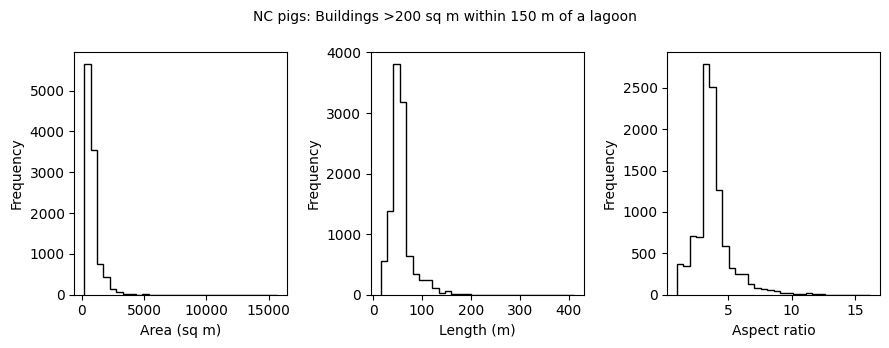

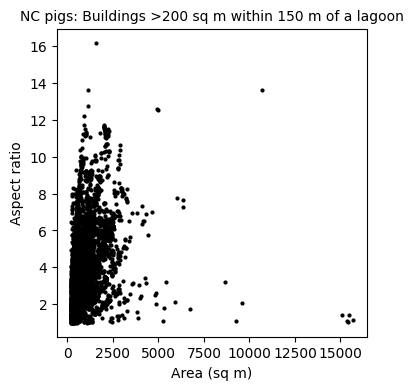

In [14]:
# Make plots of building characteristics. It turns out there are some very
# large farm buildings in this dataset, and also a lot that are pretty small.
# In the next cell we'll visualize those on a map to find out what they are

# Some buildings are duplicated as they "belong" to > 1 lagoon per farm
# Exclude them from the stats
temp = pig_buildings.drop_duplicates(['geometry'])
title = f"NC pigs: Buildings >{min_building_size} sq m within {farm_dist}\
 m of a lagoon"
explore.show_n_save(temp, default_bins, None, None, title)

# area vs aspect ratio
aspect_area(temp, title)

In [15]:
# Above about 4000 m, the buildings are often (but not always) multiple
# buildings that get merged into a single one. They are presumably the large
# but low-aspect ratio ones in the above plot. I want to keep these farms in
# the dataset that I save for possible training, because they are real farms.
# However, I will set the histogram bins and plot limits so that very large
# and potentially spurious sizes don't make the figures difficult to interpret.

# Between about 3000-4000 sq m, the buildings are either just large or they are
# connected by a structure that means that two or more buildings get identified
# as a single one in the building footprint database. I won't do anything about
# these, just note that there is some contamination there.

# Relatively small buildings, from 200-400 sq m, appear to be a mixture of
# inaccurate footprints, farm buildings that are not animal housing, and some
# small pig houses. So there is definitely some noise at this end. I will
# eventually deal with this by using only the largest building associated with
# each lagoon.

size_range = (4000, 16000)
temp = pig_buildings[(pig_buildings['Area (sq m)'] > size_range[0]) &\
                   (pig_buildings['Area (sq m)'] < size_range[1])]\
                   .drop_duplicates(['geometry'])
print(f"There are {len(temp)} buildings in this size range")

fc = geemap.geopandas_to_ee(temp[['geometry']])
temp2 = temp.set_geometry("Parent coords")
fc2 = geemap.geopandas_to_ee(temp2[['Parent coords']])

Map = geemap.Map()
Map.centerObject(fc.first().geometry(), 10)
Map.add_basemap("HYBRID")
Map.addLayer(buildings.style(**building_viz), {}, "All buildings")
Map.addLayer(lagoons_fc, {'color':'pink', 'width':6}, "All pig lagoons")
Map.addLayer(fc2, {'color':'red', 'width':6}, "Lagoons w/ bldgs in size range")
Map.addLayer(fc, {'color':'cyan', 'fillColor':'00000000'}, "Buildings in size range")

Map

There are 33 buildings in this size range


,Area (sq m),Length (m),Aspect ratio
Min,200.091240,14.959630,1.001920
Med,673.477101,51.015674,3.567928
Max,15686.996047,410.661494,16.172826


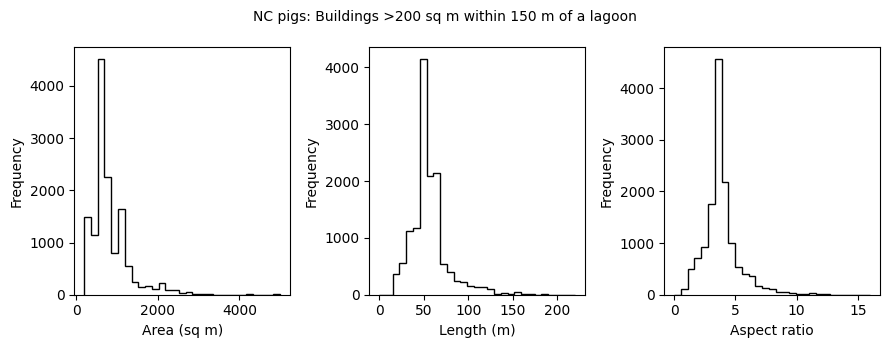

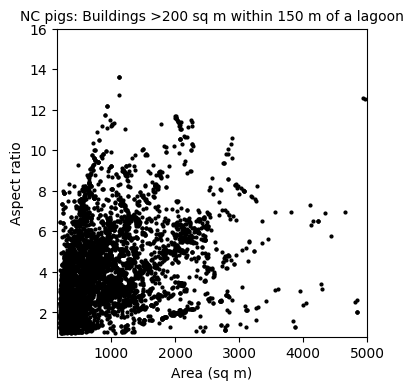

In [16]:
# Make histograms excluding buildings > 4000 sq m, then.

tailored_bins = {}
tailored_bins['Area (sq m)'] = np.linspace(min_building_size, 5000, 30)
tailored_bins['Length (m)'] = np.linspace(0, 220, 30)
tailored_bins['Aspect ratio'] = np.linspace(0, 16, 30)

# histograms and stats
explore.show_n_save(pig_buildings, tailored_bins, None, None, title)
aspect_area(pig_buildings, title, lims=((min_building_size-50, 5000), (0.8, 16)))

,Area (sq m),Length (m),Aspect ratio
Min,203.990833,17.611387,1.007682
Med,894.031505,56.485605,3.553666
Max,15686.996047,410.661494,16.172826


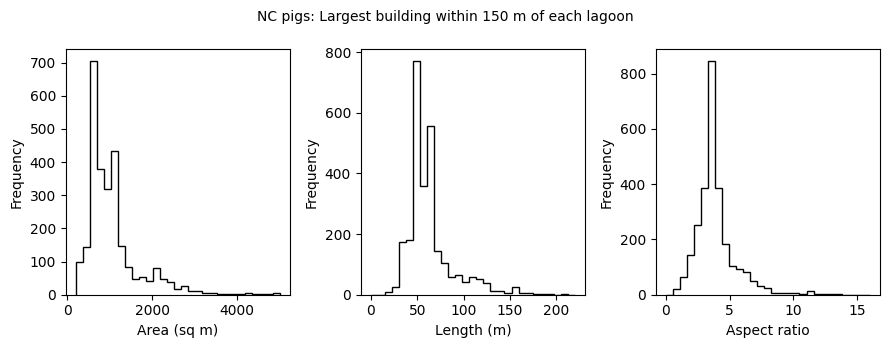

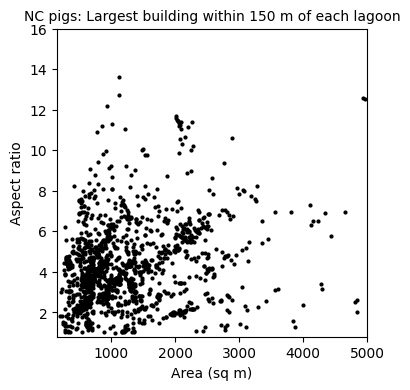

In [17]:
# From looking at the map, I know that some of the above buildings aren't animal
# housing. So let's redo the plots using only the largest building that's
# associated with each lagoon, assuming that's most likely to represent the
# animal buildings. This will be a little inaccurate because of some technical
# details to do with having multiple lagoons on some farms, but it should be
# close enough.

# Sort buildings by area then use drop_duplicates to drop all but the first
# (i.e., largest) building associated with the same lagoon. Then, drop duplicate
# builings, which get there because they're associated with >1 lagoon.

max_pig_bldgs = pig_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])\
                              .drop_duplicates(['geometry'])

title = f"NC pigs: Largest building within {farm_dist} m of each lagoon"
explore.show_n_save(max_pig_bldgs, tailored_bins, None, None, title)
aspect_area(max_pig_bldgs, title, lims=((min_building_size-50, 5000), (0.8, 16)))

## Not-farm data for North Carolina

Above, we obtained all the buildings > 200 sq m in North Carolina that are > 1000 m from a lagoon. We should be able to use those to construct a not-farm dataset to match the NC pigs dataset. However, the dataset is strongly skewed towards much smaller buildings than the actual farm building dataset. If we used that to train the CNN, it might end up being very good at separating pig farms from residential buildings, but not great at distinguishing between different types of large buildings. So I think we need to do some kind of stratified sampling. We'll roughly match the distribution of building areas that are in the max_pig_bldgs dataset.

In [18]:
sampled = explore.stratified_sample(max_pig_bldgs, other_buildings, 'Area (sq m)',\
                                 bins=tailored_bins['Area (sq m)'])

# Calculate length and aspect ratio for these buildings
notfarm_buildings = explore.get_dimensions(sampled, crs=crs)

# Sometimes there are a few aspect ratios that seem unrealistic, probably
# where the building footprint database has confused roads with buildings.
# Drop these.

notfarm_buildings = notfarm_buildings[notfarm_buildings['Aspect ratio'] < 20]

## Comparing pig, poultry, and non-farm buildings



1.   Poultry housing is larger, longer, and narrower than pig housing
2.   The non-farm sample has a similar size distribution to the NC pigs dataset, but lower aspect ratios.
3. I suspect the large, narrow NC non-farm buildings are chicken farms (I don't have NC poultry farm coords, so I can't exclude them on that basis).
4. If I tried to make the aspect ratio distribution of the non-farm sample closer to that of the pigs sample, I bet I'd just pull in more chicken farms.
5. I'm not sure whether to exclude the potential chicken farms now on the basis of their size and aspect ratio, by looking at them on a map, or by looking at the actual training data as I'm making it. I'll probably go with the final option.



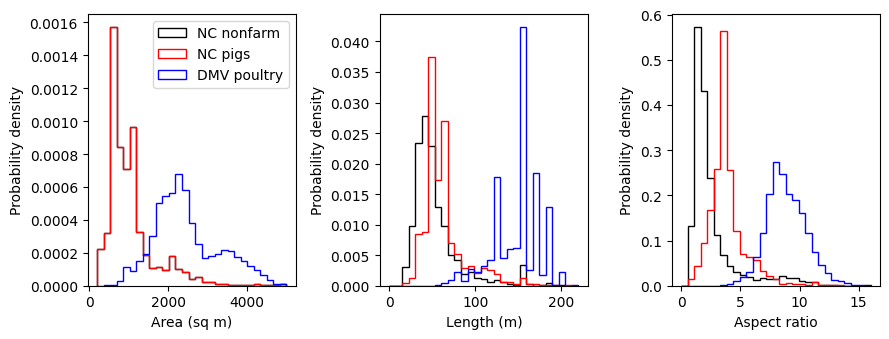

In [19]:
# Now let's look at the pig, poultry, and non-farm data at the same time
# We'll define consistent bins for both datasets

_, axes = plt.subplots(1, 3, figsize=(9, 3.5))

cols = ['Area (sq m)', 'Length (m)', 'Aspect ratio']

for ax, col in zip(axes, cols):
  for df, color, leg in  zip([notfarm_buildings, max_pig_bldgs, dmv],\
                             ['k', 'r', 'b'],\
                             ['NC nonfarm', 'NC pigs', 'DMV poultry']):
    ax.hist(df[col], bins=tailored_bins[col], color=color, histtype='step',\
            density=True, label=leg)
  if col == "Area (sq m)":
    ax.legend()
  ax.set_xlabel(col)
  ax.set_ylabel('Probability density')

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/CAFO_data/Analysis/DMV_NC_hist.png')

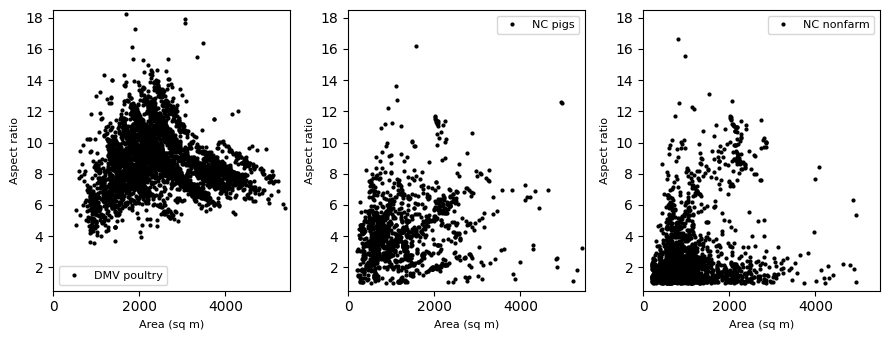

In [20]:
_, axes = plt.subplots(1, 3, figsize=(9, 3.5))

for df, ax, label in zip([dmv, max_pig_bldgs, notfarm_buildings], axes,\
                         ['DMV poultry', 'NC pigs', 'NC nonfarm']):

  ax.plot(df['Area (sq m)'], df['Aspect ratio'], 'ko', ms=2, label=label)
  ax.legend(fontsize=8)
  ax.set_xlim(0, 5500)
  ax.set_ylim(0.5, 18.5)
  ax.set_xlabel("Area (sq m)", fontsize=8)
  ax.set_ylabel("Aspect ratio", fontsize=8)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/CAFO_data/Analysis/DMV_NC_aspect_area.png')

## Final datasets

Here we will ensure that all dfs have a consistent set of columns, and concatenate the NC farm and not-farm building DFs. Then we will pickle the final DMV and NC dataframes.

In [31]:
# DMV Poultry

# Add the remaining columns with appropriate values, reorder, save

coldict = {"Dataset name": "DMV poultry", "Parent coords": None}
for col, val in coldict.items():
  dmv.loc[:, col] = val

dmv = explore.re_order(dmv)
dmv.to_pickle(f'/content/drive/MyDrive/CAFO_data/forTraining/interim_files/DMV_poultry_bldgs.pkl')


# NC Pigs

# Add the remaining columns with appropriate values, reorder, concatenate farm
# and non-farm buildings, save
max_pig_bldgs.loc[:, "Dataset name"] = "NC pigs"
max_pig_bldgs = explore.re_order(max_pig_bldgs)

coldict = {"Dataset name": "NC pigs", "Parent coords": None,\
           "Farm type": "Non-farm", "Number of animals": np.nan}
for col, val in coldict.items():
  notfarm_buildings.loc[:, col] = val

notfarm_buildings = explore.re_order(notfarm_buildings)

nc_pigs = pd.concat([max_pig_bldgs, notfarm_buildings])
nc_pigs.to_pickle(f'/content/drive/MyDrive/CAFO_data/forTraining/interim_files/NC_pigs_bldgs.pkl')

# The future warning arises because the dtypes of the Parent coords column can be
# different (geometry vs float). Not sure what if anything to do about that.